In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

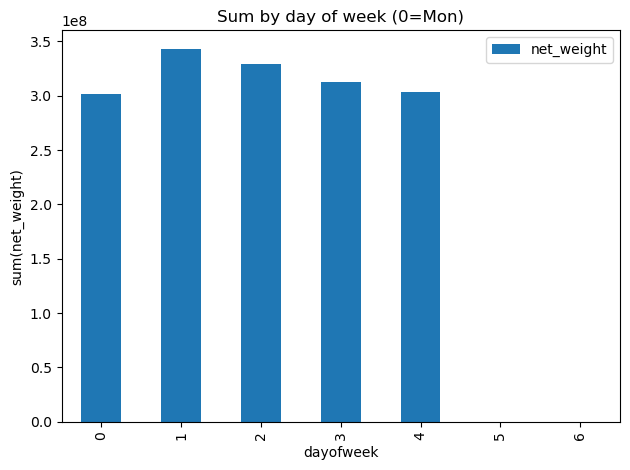

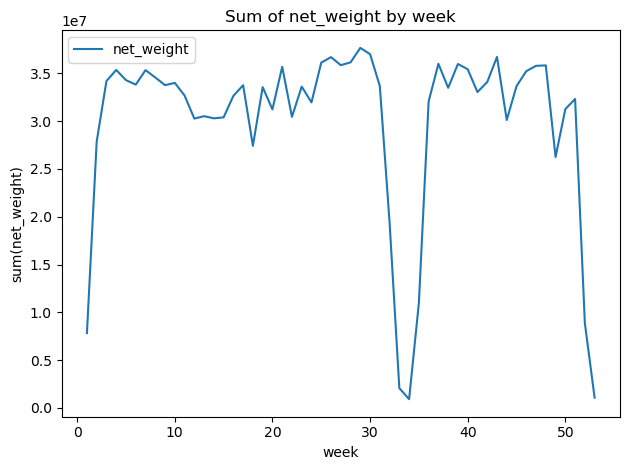

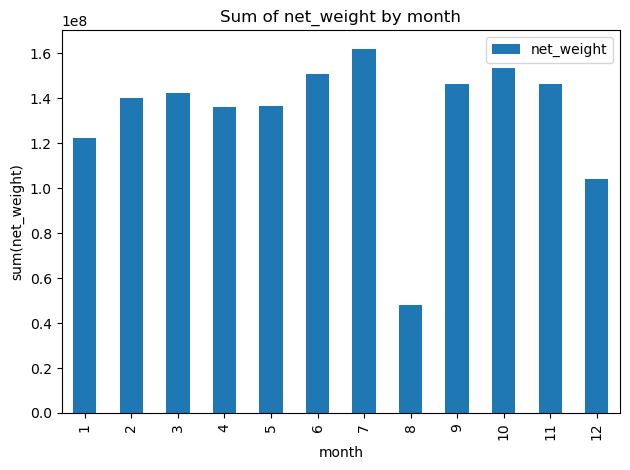

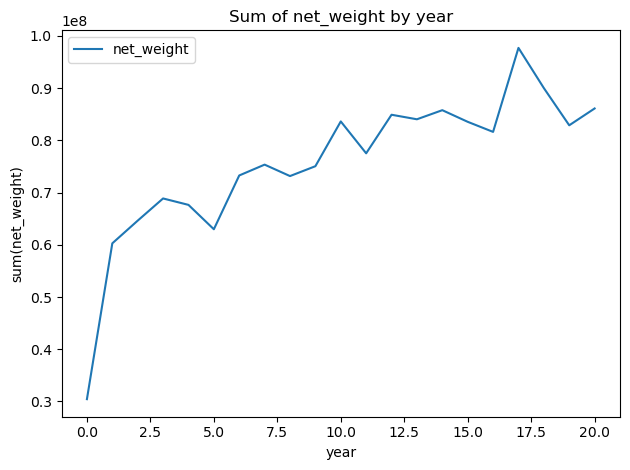

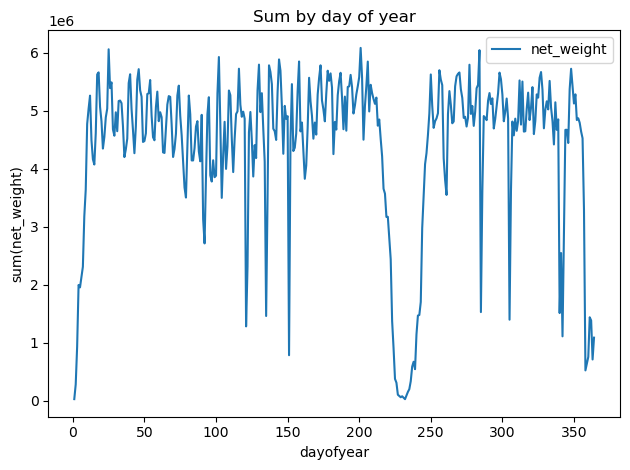

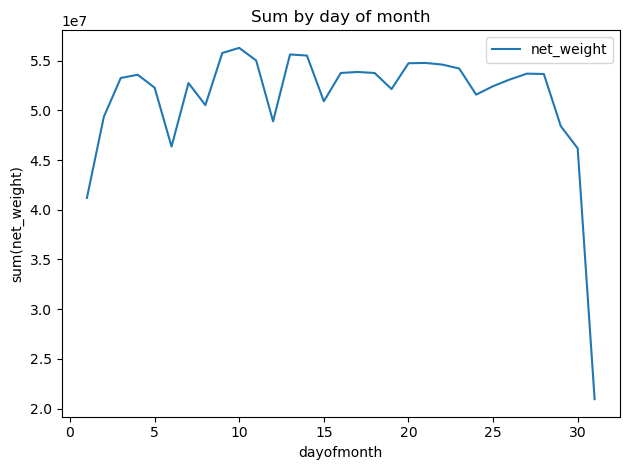

In [2]:
receivals = pd.read_csv('../data/kernel/receivals.csv')
receivals = receivals[receivals["net_weight"] > 0]
#df_nan = receivals[receivals["net_weight"].isna()]

receivals['date_arrival'] = (
    pd.to_datetime(receivals['date_arrival'], utc=True)
      .dt.tz_localize(None)
      .dt.normalize()
)

daily = (
    receivals.groupby(["rm_id","date_arrival"], as_index=False)
             .agg(
                 net_weight_sum=("net_weight", "sum")
             ).rename(columns={"date_arrival": "date","net_weight_sum":"net_weight"})
             .sort_values(["rm_id","date"])
)
daily["year"] = daily["date"].dt.year-2004
daily["month"] = daily["date"].dt.month
daily["week"] = daily["date"].dt.isocalendar().week
daily["dayofmonth"] = daily["date"].dt.day 
daily["dayofweek"] = daily["date"].dt.dayofweek
daily["dayofyear"] = daily["date"].dt.dayofyear

def plot_sum_by(feature: str, title=None):
    agg = daily.groupby(feature, as_index=False)["net_weight"].sum().sort_values(feature)
    ax = agg.plot(x=feature, y="net_weight", kind="bar" if feature in {"month","dayofweek"} else "line")
    ax.set_title(title or f"Sum of net_weight by {feature}")
    ax.set_xlabel(feature)
    ax.set_ylabel("sum(net_weight)")
    plt.tight_layout()
    plt.show()

plot_sum_by("dayofweek", "Sum by day of week (0=Mon)")    # 0..6
plot_sum_by("week", "Sum of net_weight by week")      # 1..53
plot_sum_by("month", "Sum of net_weight by month")        # 1..12
plot_sum_by("year", "Sum of net_weight by year")         
plot_sum_by("dayofyear", "Sum by day of year")            # 1..366
plot_sum_by("dayofmonth", "Sum by day of month")          # 1..31



## Conclusion : 
We understand that the deliveries depend of some features about the current day.
Especially, the day of the week is important (no deliveries the weekend -> create a feature IsWeekend).
And the month is important because in August (and December) we see an important drop of the amount of the deliveries

In [5]:
stats = (
    daily.groupby("rm_id")
            .agg(
                last_delivery=("date", "max"),
                total_deliveries=("date", "count")  # number of delivery-days
            )
)
cutoff = pd.Timestamp("2024-12-31") - pd.DateOffset(years=2)
cond1 = (stats["last_delivery"] <= cutoff) & (stats["total_deliveries"] <= 30 )
cond2 =(stats["last_delivery"] <= pd.Timestamp("2006-01-01"))
rare_rm_id = stats.index[cond1 | cond2]
print(f"We don't have enough information to forecast the following rm_id :\n{rare_rm_id}")
print(f"number :  {len(rare_rm_id)}")
daily = daily[~daily["rm_id"].isin(rare_rm_id)].reset_index(drop=True)


We don't have enough information to forecast the following rm_id :
Index([ 342.0,  343.0,  345.0,  346.0,  347.0,  348.0,  353.0,  354.0,  355.0,
        357.0,  358.0,  360.0,  362.0,  364.0,  365.0,  366.0,  367.0,  368.0,
        369.0,  374.0,  375.0,  378.0,  379.0,  380.0,  381.0,  383.0,  387.0,
        388.0,  389.0,  390.0, 1842.0, 1843.0, 1844.0, 1845.0, 1846.0, 1850.0,
       1851.0, 1852.0, 1853.0, 1854.0, 1857.0, 1858.0, 1866.0, 1867.0, 1868.0,
       1871.0, 1872.0, 1873.0, 1874.0, 1882.0, 1981.0, 2001.0, 2061.0, 2102.0,
       2121.0, 2122.0, 2128.0, 2139.0, 2141.0, 2148.0, 2156.0, 2158.0, 2201.0,
       2223.0, 2282.0, 2283.0, 2285.0, 2302.0, 2304.0, 2322.0, 2323.0, 2341.0,
       2343.0, 2344.0, 2345.0, 2347.0, 2348.0, 2362.0, 2363.0, 2402.0, 2421.0,
       2481.0, 2521.0, 2561.0, 2742.0, 2821.0, 2841.0, 2861.0, 3022.0, 3101.0,
       3144.0, 3222.0, 3241.0, 3481.0, 3501.0, 3541.0],
      dtype='float64', name='rm_id')
number :  96


# Conclusion
We have some rm_id (almost half of the rm_ids) that don't have a lot of deliveries in 20 years and some rm_id what are not delivered anymmore.
We choosed to remove these rm_id with 2 conditionts (cond1 and cond2 in the code) to increase the speed of the training and to avoid spontaneous predictions from nothing that can impact the result

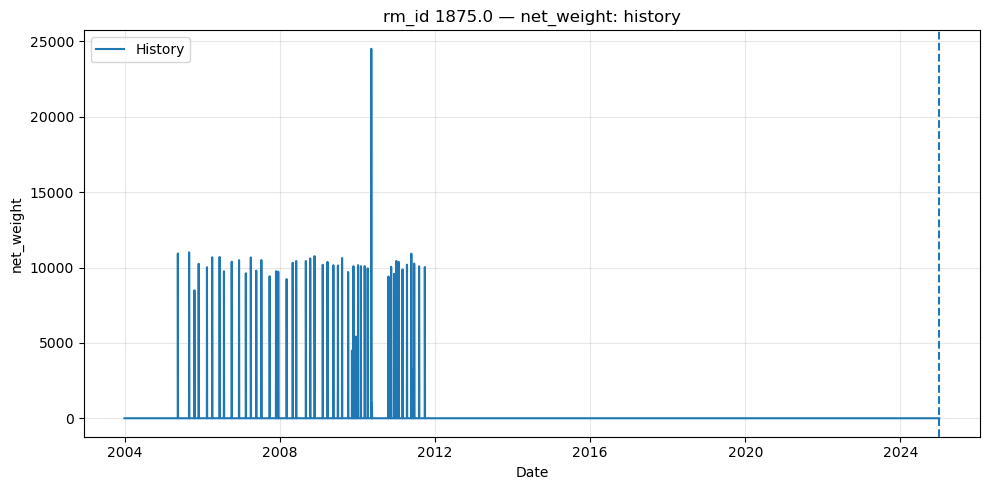

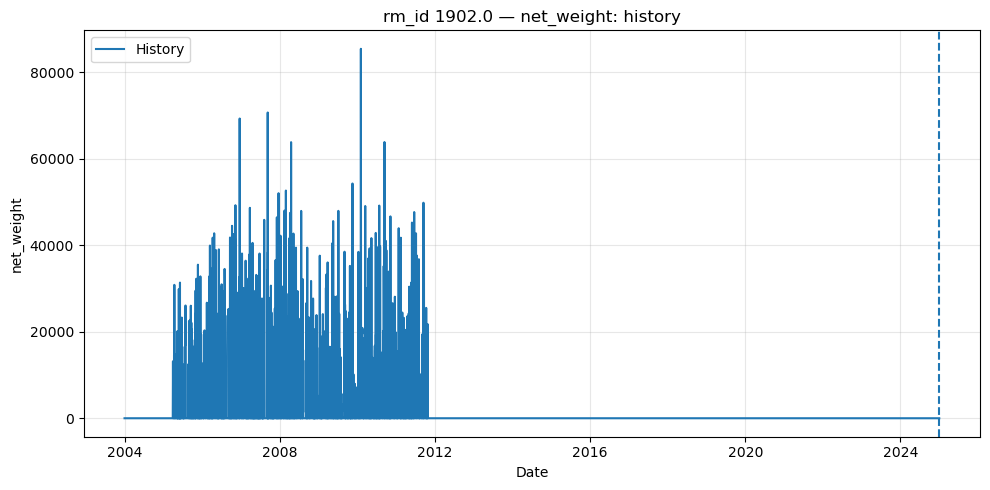

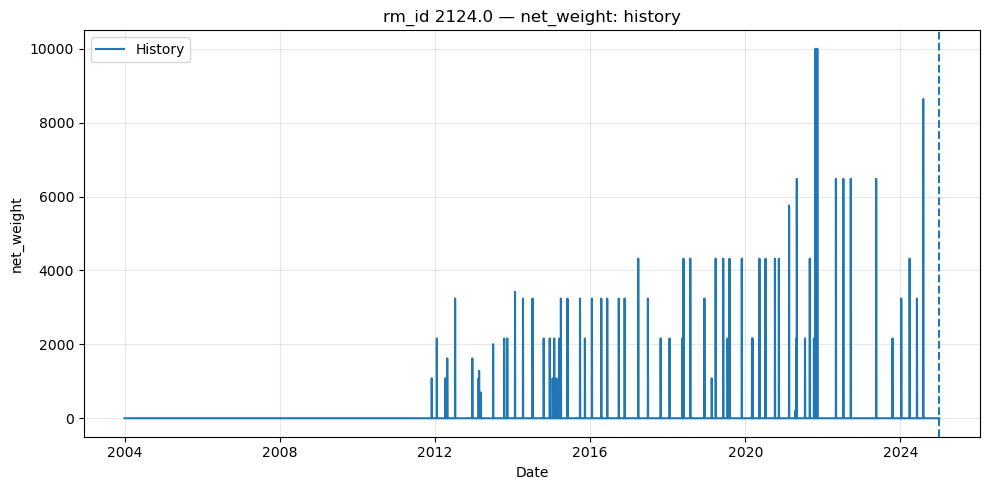

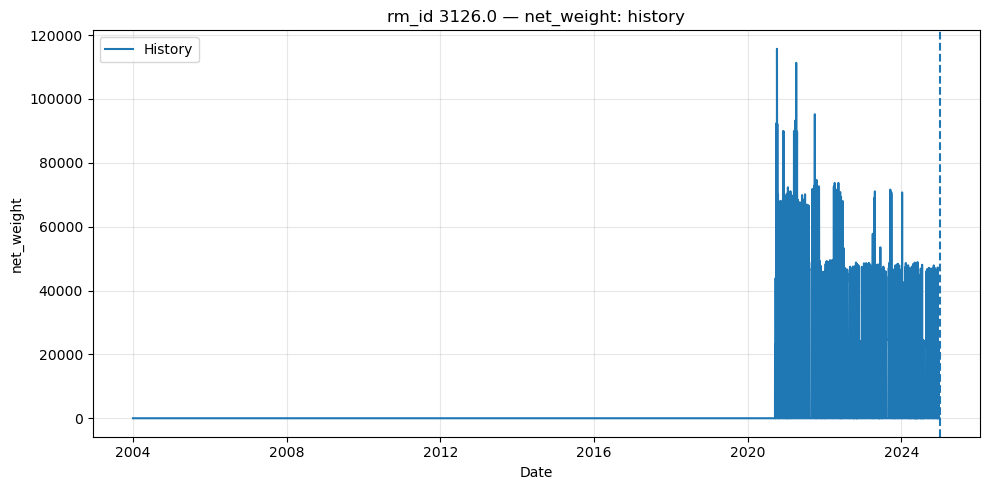

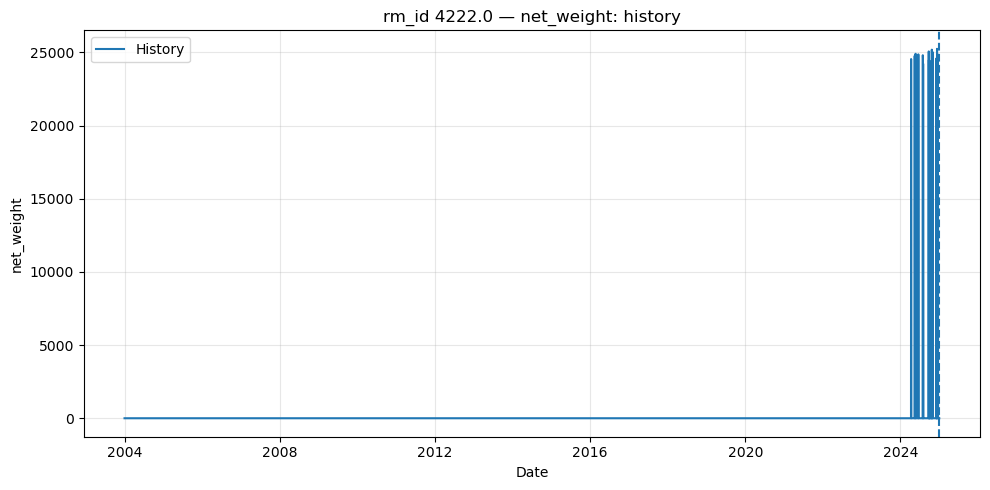

In [12]:
def plot_history(df_all, rm_id,start_date="2004-01-01"):
    # ensure types
    hist = df_all.loc[(df_all["rm_id"] == rm_id) & (df_all["date"] >= pd.Timestamp(start_date)), ["date", "net_weight"]].copy()

    # plot
    plt.figure(figsize=(10, 5)) 
    plt.plot(hist["date"], hist["net_weight"], label="History")

    # reference line for forecast start (optional)
    fs = pd.Timestamp("2025-01-01")
    plt.axvline(fs, linestyle="--")

    plt.title(f"rm_id {rm_id} — net_weight: history")
    plt.xlabel("Date")
    plt.ylabel("net_weight")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

full_start = pd.Timestamp("2004-01-01")
full_end   = pd.Timestamp("2024-12-31")
rm_ids = pd.Index(daily["rm_id"].unique(), name="rm_id")
calendar = pd.date_range(full_start, full_end, freq="D", name="date")
full_idx = pd.MultiIndex.from_product([rm_ids, calendar], names=["rm_id","date"])

daily = (
    daily.set_index(["rm_id","date"])["net_weight"]
         .reindex(full_idx, fill_value=0)
         .reset_index()
)
plot_history(daily,1875.)
plot_history(daily,1902.)
plot_history(daily,2124.)
plot_history(daily,3126.)
plot_history(daily,4222.)

# Conclusion
The deliveries highly depend of the rm_id but there are some commun specificities between some group of rm_id. We added some static features about each rm_id. Among them there are "delay_last_deliverie" (difference in days between the 1st january 2025 and the last deliverie day), the number of deliveries all time, mean/median/sum of the netweight column

In [14]:
materials = pd.read_csv('../data/extended/materials.csv')
print(materials.columns)
materials = materials.dropna(subset=["rm_id"])

print(materials["raw_material_alloy"].head())
print(materials["stock_location"].head())

Index(['rm_id', 'product_id', 'product_version', 'raw_material_alloy',
       'raw_material_format_type', 'stock_location'],
      dtype='object')
1    SB06 Traders
2     SB02 606035
3     SA10 606035
4     SA15 600540
5     SA13 606020
Name: raw_material_alloy, dtype: object
1    DELETED_28.02:2011_SB06 anodiz
2                             SB 02
3           DELETED_28.02:2011_ST01
4      DELETED_28.02:2011_SA 300370
5      DELETED_28.02:2011_SA13 6035
Name: stock_location, dtype: object


# Conclusion 
In the dataset materials there are string values in "raw_material_alloy" and "stock_location" that are similar between diferent rm_id.
Thus, we created families and localisations that are boolean features to know if some rm_id share a commun name or a commun localisation

In [16]:
transportation = pd.read_csv('../data/extended/transportation.csv')

transportation = transportation.dropna(subset=["purchase_order_id","net_weight","rm_id"])
print(transportation.columns)
print(transportation["transporter_name"].unique())

Index(['rm_id', 'product_id', 'purchase_order_id', 'purchase_order_item_no',
       'receival_item_no', 'batch_id', 'transporter_name', 'vehicle_no',
       'unit_status', 'vehicle_start_weight', 'vehicle_end_weight',
       'gross_weight', 'tare_weight', 'net_weight', 'wood', 'ironbands',
       'plastic', 'water', 'ice', 'other', 'chips', 'packaging', 'cardboard'],
      dtype='object')
['Transporter0' 'Transporter1' 'Transporter2' 'Transporter3'
 'Transporter4' 'Transporter5' 'Transporter6' 'Transporter7'
 'Transporter8' 'Transporter9' 'Transporter10' 'Transporter11'
 'Transporter12' 'Transporter13' 'Transporter14' 'Transporter15'
 'Transporter16' 'Transporter17' 'Transporter18' 'Transporter19'
 'Transporter20' 'Transporter21' 'Transporter22' 'Transporter23'
 'Transporter24']


# Conclusion :
There are 25 different transporters so we created dummies for these transporters. There are some float values what are not directly related to an rm_id such as "tare_weight" or "gross_weight". We choosed to add some information about these column (mean) because it can hide information usefull for an AI.

Remarks :

- I didn't use purchase_orders.csv in the XGBoost model because there are no unique link  between one product_id and one rm_id so I didn't succed to use this data_frame in a daily prediction of weight. In the file "predict_receivals_with_orders.ipynb" I tried to predict receivals with orders without good results.
- In the file "XGB_lags_analysis" you can find what I did to find the most correlated lags to "net_weight" to improve my model and create lag features.
- In XGBoosts_Find_parameters" I created a loop on several hyperparameters to find the best parameters for an XGB model.